# LightGBM

[Ke et al. (2017). Lightgbm: A highly efficient gradient boosting decision tree.](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)

## 概要

LightGBMは

- **pre-pruning** （決定木の枝をそれ以上分岐させても予測が改善しなくなったら分割を停止する剪定方法）
- **best-first** （情報利得が最大の枝から順に伸ばす。pre-pruningが使える。）
- **histogram-based** （連続値の特徴量をbinに離散化することで最適な分割点の探索の計算量を激減させる）

という決定木の高速化に関する既存の技術と、

- **Gradient-based One-Side Sampling** （勾配の情報を活用して近似精度の良いサブサンプリングをする）
- **Exclusive Feature Bundling** （one-hot encodingをしたように相互に排他的になっているスパースな特徴量をlabel encodingをした特徴量のような密な特徴量にまとめることで効率良く学習する）

というLightGBM自身が新たに提案した2つの技術を使った、高速で精度の良い勾配ブースティング決定木。

## 現代的なGBDTの学習の流れ

（[Shi et al. (2022). Quantized training of gradient boosting decision trees.](https://arxiv.org/pdf/2207.09682.pdf)より）

勾配ブースティング決定木（GBDT）は複数の決定木を組み合わせるアンサンブル学習のアプローチをとる。

各iterationでは現状の予測値に基づくGradientとHessianを計算し、負の勾配を近似するように決定木を学習する。

$k+1$回目の反復において、現状のサンプル$i$の予測値を$\hat{y}_i^k$とすると、誤差関数$l$のgradient$g_i$とhessian$h_i$は

$$
g_i=\frac{\partial l\left(\hat{y}_i^k, y_i\right)}{\partial \hat{y}_i^k},
\quad
h_i=\frac{\partial^2 l\left(\hat{y}_i^k, y_i\right)}{\left(\partial \hat{y}_i^k\right)^2}
$$

となる。

葉$s$について、葉に含まれるデータの番号（index）の集合を$I_s$とする。葉$s$における$g_i$と$h_i$のサンプルについての合計を

$$
G_s = \sum_{i\in I_s} g_i,
\quad
H_s = \sum_{i\in I_s} h_i
$$

と表記することにすると、反復$k+1$回目において木構造が固定された下で、訓練誤差は二次のテイラー近似により

$$
\mathcal{L}_{k+1} \approx \mathcal{C}+\sum_s\left(\frac{1}{2} H_s w_s^2+G_s w_s\right)
$$

と表すことができる。

ここで$\mathcal{C}$は定数で、$w_s$は葉$s$の予測値である。近似誤差の最小化により最適値が得られる

$$
w_s^*=-\frac{G_s}{H_s}, \quad \mathcal{L}_s^*=-\frac{1}{2} \cdot \frac{G_s^2}{H_s}
$$

最適な木構造を探すのは困難であるため、木は貪欲かつ反復的に訓練される。

葉$s$を2つの子$s_1, s_2$に分割するとき、近似損失の減少分は次のように計算できる。

$$
\Delta \mathcal{L}_{s \rightarrow s_1, s_2}=\mathcal{L}_s^*-\mathcal{L}_{s_1}^*-\mathcal{L}_{s_2}^*=\frac{G_{s_1}^2}{2 H_{s_1}}+\frac{G_{s_2}^2}{2 H_{s_2}}-\frac{G_s^2}{2 H_s}
$$

葉$s$にとっての最適な分割条件の探索は、すべての特徴のすべての分割候補点を数え上げて、最も損失の減少が多いものが選ばれる。

最適分割点の探索を高速化するために用いられるのはヒストグラムである。histogram based GBDTの基本的なアイデアは特徴量の値をbinsに分割する。histogramのbinsは、そのbinに含まれるデータのgradientsとhessiansの総和が記録されている。binsの境界値のみが分割候補点になる。

> Algorithm 1 Histogram Construction for Leaf $s$
> 
> Input: Gradients $\left\{g_1, \ldots, g_N\right\}$, Hessians $\left\{h_1, \ldots, h_N\right\}$ <br>
> Input: Bin data data $[N][J]$, Data indices in leaf $s$ denoted by $I_s$ <br>
> Output: Histogram ${hist}_s$ <br>
> for $i \in I_s, j \in\{1 \ldots J\}$ do <br>
>   bin $\leftarrow \operatorname{data}[i][j]$ <br>
>   $hist_s[j][bin] . g \leftarrow$  $hist_s[j][$ bin $] . g+g_i$ <br>
>   $hist_s[j][b i n] . h \leftarrow$  $hist_s[j][b i n] . h+h_i$ <br>
> end for


## LightGBMが使う既存の技術

### pre-pruning

（この節とその次の節はほぼShi, 2007の序盤の説明をまとめたもの）

決定木のすべてのノードの不純度がゼロになるような完全に成長させきった状態にしてしまうと過学習の問題が発生する。そのため、剪定（pruning）を行ってほどよい木の大きさにする必要がある。pruningの方法は次の2種類に分けられる（Shi, 2007）。

- pre-pruning：木を拡張させることによる予測の改善がなくなったら（それ以上分割すると誤差が増えるなら）木の拡張を停止する。
- post-pruning：一度木を完全に成長させて、それから一番予測精度が良かった木のサイズを選択する。
- pre-pruningのほうが無駄な計算を避けられる可能性があり効率的だが、本当に最適な木の大きさになる前に学習を停止させてしまう、「early stopping」という問題がある。

#### early stopping問題

決定木が各ノードで分割をする際は、一つの特徴量だけを使って情報利得を評価して分割する。そのため、複数の特徴量を組み合わせると予測精度が上がるような効果（交互作用効果）を評価することはできない。

以下の表はあるデータセットを表しており、a,bが特徴量でclassが目的変数である。a,bの両方を使うと正確に分類できるが、単体では予測に寄与しない。



| a    | b    | class |
| ---- | ---- | ----- |
| 0    | 0    | 0     |
| 0    | 1    | 1     |
| 1    | 0    | 1     |
| 1    | 1    | 0     |



このデータのように **交互作用効果しかもたず単体では予測に寄与しない特徴量だけを含むデータセットでは、pre-pruningの決定木は分割を行わずに学習を終了してしまう。** この問題があるためにpre-pruningはあまり評価されず、post-pruningの手法が開発された。

しかし、 **実世界のデータセットではこの問題はあまり起きない** という報告もある。Frank（2000）やShi（2007）は数十個のオープンなデータセットを使ってpre-pruningとpost-pruningを比較し、pruningのパラメータ調整によっては両者のパフォーマンスに大きな差が生まれないことを示した。

（考察：これは私の仮説だが、parity problemのように「単体ではまったく予測に寄与しないが交互作用はある」というデータセットは実データでは稀ということかもしれない。ちなみにLightGBMはparity problemを解くことはできないが、aとbを掛け合わせた変数を追加してやれば解くことができるので特徴量の工夫で対応できないことはない）

## best-first (leaf-wise) tree

標準的な決定木はdepth-firstという種類のアルゴリズムを使っているが、LightGBMが使っているのはbest-firstというタイプのものである。それぞれの特徴は次の通り。

1. **best-first** ：木を分岐していく各ステップで、すべての分割可能なノードの中でもっとも不純度を低下させるノードを分割する。
2. **depth-first** ：ノードの分割の順番は固定（通常は左の枝が先に分割される）

両者は木が最大に成長した時に得られる木は一緒だが、best-firstは最良のノードから分割していくので、pre-pruningを使うことができる。

## histogram-based

GBDTの計算量の大部分は最適な分岐点の探索にある。これまでに研究されてきた分岐点の探索の高速化にはpre-sortedアルゴリズムとhistogram-basedアルゴリズムの2つがある。

1. **pre-sorted** ：事前に特徴量をソートしておき、すべての分割可能な点を評価して最適な分割点を探す。正確だが計算量が非常に多い。
2. **histogram-based** ：連続値の特徴量を離散化して少ない数（例えば256個とか）のbinにして、その中で最適な分割点を探す。binの数だけ評価すればいいので分割点の探索自体の計算量は非常に少ない。


histogram-basedアルゴリズムを使うほうが大幅に高速化ができるので、LightGBMはこちらをベースに研究している。

#### 考察：予測精度は激減しないのか？

例えば100万レコードあって100万のユニークな値がある特徴量を256個のbinに離散化するようなことを考えると、値を減らしすぎではないか？予測精度も大きく悪化してしまうのではないか？と思ってしまう。

しかし、実証的には問題ないという報告がある。LightGBMが参照している先行研究のひとつであるLi et al.（2008）ではbinの数を65536個にしたときと256個にした時でtestデータに対するNDCGスコアの差はほとんど無かったと報告している。また、LightGBMの論文もXGBoostのexact greedy algorithm（pre-sorted algorithmのこと）を使ったモデルよりもよい精度を出している。

理論的に問題ないのかについての回答は、いまのところ私は見つけられていない。しかし、現在のところ私は2つの仮説を考えている。

1. LightGBMのAlgorithm 1を見た感じだと、分割の探索のたびにそのノードに含まれるデータを使ってヒストグラムを作っていると思われる。そのため、1種類のbinsだけで学習するのではなく色々な分割の仕方をした多様なbinsを使って評価している。また、根ノードから伸びていった子孫のノードは含まれるサンプルサイズもある程度減っているため、最初の分割は大雑把でも続く分割は徐々に近似誤差が小さい分割ができており、仮に根ノードでの分割でbinsにまとめたことによる誤差が多かったとしても、子孫のノードでその誤差を補うことができているのかもしれない。
2. そもそもブースティング自体が弱学習器をたくさん使って強い学習器を作る技術なので、個別の弱学習器が多少さらに弱くなったとしても、少し反復数を増やせばその損失を補えるのかもしれない。


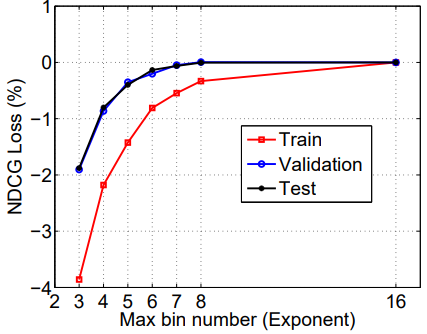

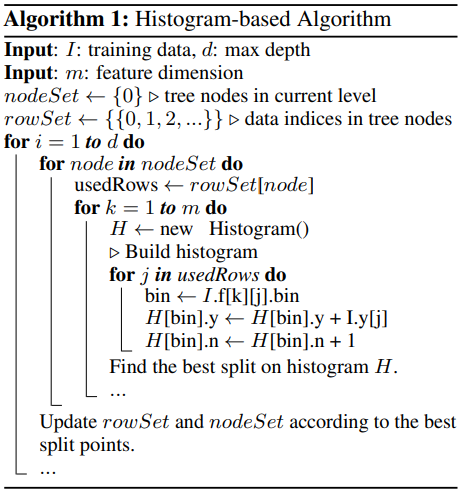

## LightGBMが新たに提案した技術

### 背景

histogram-basedのGBDTは、ヒストグラムの作成に$O(\text{#data} \times \text{#feature})$かかり、分岐点の探索に$O(\text{#bin} \times \text{#feature})$かかる。つまり、計算量の大部分はヒストグラムの作成が占めている。

そこでLightGBMでは、#dataを減らすためにGOSSという技術を導入し、#featureを減らすためにEFBという技術を使う。

### Gradient-based One-Side Sampling（GOSS）

サンプルサイズを減らす際、もっともシンプルなのがランダムサンプリングすることである。Stochastic Gradient Boosting（Friedman, 2002）は決定木を作る際にランダムサンプリングした部分サンプルを使って学習していたが、ランダムサンプリングは近似精度がそんなに良いわけではないので、この方法は一般には予測精度を下げる。

AdaBoostをベースにしているならデータインスタンスに対する重みを持っているので、それを使って適応的にサンプリングすることができてより効果的だが、GBDTには明示的な重みはないので、この方法を直接適用することはできない。

GBDTの勾配はAdaBoostの重みに相当するもので、インスタンスの重要度の指標に使うことができる（勾配が小さい＝訓練誤差が小さい＝十分に予測できている＝学習済み）。そこでGOSSは勾配の情報を使ってサンプリングを行う。

勾配が小さいサンプルをすべて削除するような処理にしてしまうとデータの分布が変化して予測精度に悪影響が出るため、**GOSSは大きい勾配を持つインスタンスは残して、小さい勾配を持つインスタンスに対してはランダムサンプリングを行う。**

具体的には、GOSSはまずデータインスタンスを勾配の絶対値に従って並び替え、上位$a\times 100\%$のインスタンスを選ぶ。そして残りのデータから$b \times 100\%$のインスタンスをランダムにサンプリングする。その後、情報利得の計算の際にサンプリングされた小さい勾配のデータを定数$\frac{1-a}{b}$で増幅する（勾配が少ないインスタンスの勾配の総和がサンプリング前と同じになるように増やしている）。

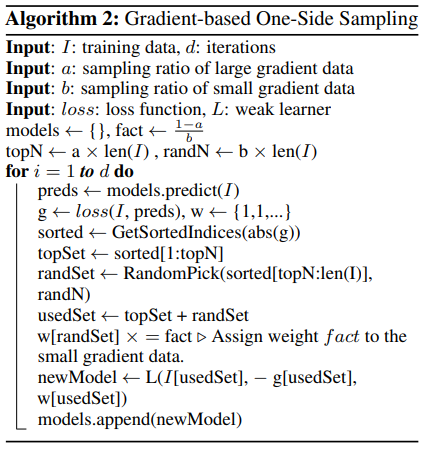

これは多くの場合で近似精度がランダムサンプリングより優れている（詳しくは論文の3.2節の理論解析を参照）。

## Exclusive Feature Bundling（EFB）
特徴量の次元数が大きいデータセットは、スパースであることが多い。スパースなデータは情報を損失することなく次元削減できる可能性がある。

具体的には、相互に排他的な（同時にゼロでない値をとることが無い）特徴量を1つの特徴量にまとめることで、安全に次元数を減らすことができる。

これは2つのステップからなり、

1. まずGreedy Bundlingというアルゴリズムでは、値の衝突（conflict：同時に非ゼロの値をとること）の回数が一定の閾値以下であれば同じbundle（特徴量の束）に追加していく。
2. つぎに、Merge Exclusive Featuresというアルゴリズムで、同じbundleに含まれる特徴量を、それぞれの値が取る範囲がかぶらないように範囲をシフトさせつつ一つの特徴量にまとめる。
    - 例えば、$[0, 10)$の値をとる特徴量と$[0, 20)$の値をとる特徴量がある場合、後者に10を足して$[10, 30)$にして両者をマージする。

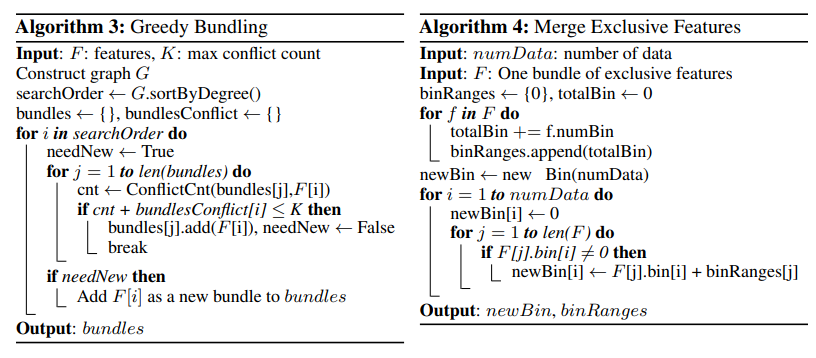

## 実験結果

5つのオープンなデータセットで比較を行い、GOSSとEFBを使うことで6~21倍高速化していること、そんな高速化をしてもXGBoostでexact greedy algorithmに匹敵する（というか少し上回る）精度を出していることを示した。

また、SGBとGOSSの精度を同じサンプリング比率の下で比べた時は常にGOSSのほうが少し精度が高くなっており、「ランダムサンプリングよりも勾配の情報を使ってサンプリングしたほうがサンプリングの近似精度が良い」という理論と整合的な結果も出ている。

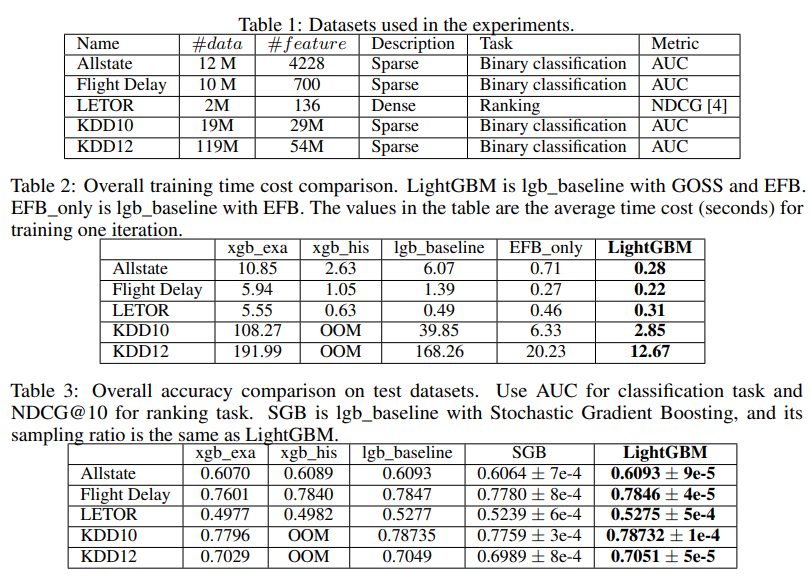